In [ ]:
#!pip install openpyxl for reading excel

In [ ]:
# import data_cleaning as dc
# dc.main()

c:\Users\nuwai\Anaconda3\envs\myenv\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


The first step in our pipeline involves loading the data into a pandas DataFrame. This is accomplished using the pandas library, which is imported at the beginning of the script.

In [18]:
# Step 1: Load the data
import pandas as pd
import data_preprocessing as dp
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

df = pd.read_csv('./data/MMNames_clean.csv')

In [16]:
df.groupby('SR_Name')['name'].count()

SR_Name
Ayeyarwady      2178
Bago (East)      921
Bago (West)      814
Chin             648
Kachin           878
Kayah            228
Kayin            552
Magway          2244
Mandalay        1903
Mon              600
Nay Pyi Taw      234
Rakhine         1331
Sagaing         3278
Shan (East)      257
Shan (North)    1476
Shan (South)     616
Tanintharyi      524
Yangon           831
Name: name, dtype: int64

In [17]:
df['SR_Name'].value_counts(normalize=True)

SR_Name
Sagaing         0.167991
Magway          0.115000
Ayeyarwady      0.111618
Mandalay        0.097525
Shan (North)    0.075642
Rakhine         0.068211
Bago (East)     0.047199
Kachin          0.044996
Yangon          0.042587
Bago (West)     0.041716
Chin            0.033209
Shan (South)    0.031569
Mon             0.030749
Kayin           0.028289
Tanintharyi     0.026854
Shan (East)     0.013171
Nay Pyi Taw     0.011992
Kayah           0.011685
Name: proportion, dtype: float64

Text(0, 0.5, 'Proportion')

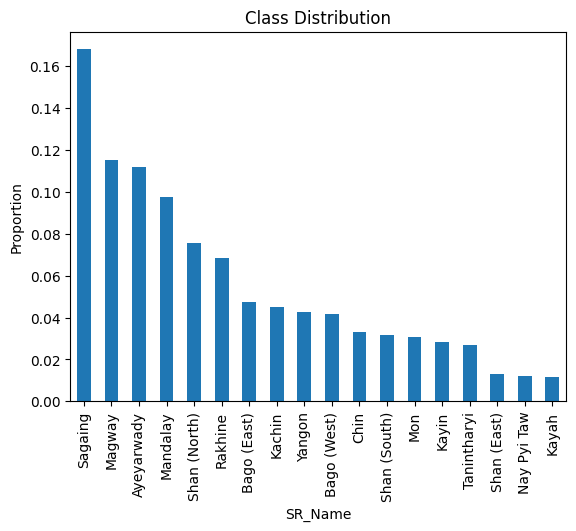

In [22]:
import matplotlib.pyplot as plt

df['SR_Name'].value_counts(normalize=True).sort_values(ascending=False).plot(kind='bar')
plt.title("Class Distribution")
plt.ylabel("Proportion")

In [19]:
df = dp.clean_name_column(df, 'name')

In [20]:
df['name'] = df['name'].str.lower()

In [24]:
# Step 2: Prepare the data

df = dp.preprocess_category(df,'SR_Name')
df = dp.preprocess_onehot(df,'name')

y = df['SR_Name'].values 
X = df.drop(columns=['SR_Name']).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42,stratify=y)
print(X_train.shape, X_test.shape)


(13659, 12488) (5854, 12488)


In [25]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))
print(class_weights_dict)

{0: 0.49792213473315833, 1: 1.1764857881136952, 2: 1.3312865497076023, 3: 1.67143906020558, 4: 1.235884907709012, 5: 4.742708333333334, 6: 1.9658894645941278, 7: 0.4830256736685763, 8: 0.5696946946946947, 9: 1.8067460317460318, 10: 4.627032520325203, 11: 0.8141988555078684, 12: 0.3307904678872421, 13: 4.215740740740741, 14: 0.7345918038076799, 15: 1.7606341840680588, 16: 2.067665758401453, 17: 1.3038373424971363}


In [26]:
# Step 3: Build a NN model with TensorFlow
import tensorflow as tf

def create_classification_model(input_shape, num_classes, params={}):
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=input_shape),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [12]:
import numpy as np
import pandas as pd
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    accuracy_score,
    top_k_accuracy_score
)
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_classification_model(model, X, y_true, output_path, prefix="test", batch_size=32, top_k=3, label_encoder=None):
    # Predict probabilities
    y_probs = model.predict(X, batch_size=batch_size, verbose=0)
    y_pred = np.argmax(y_probs, axis=1)

    # Accuracy
    acc = accuracy_score(y_true, y_pred)
    
    # Top-k Accuracy (optional)
    top_k_acc = top_k_accuracy_score(y_true, y_probs, k=top_k)

    # Classification Report
    report = classification_report(y_true, y_pred, output_dict=True)
    report_df = pd.DataFrame(report).round(2).transpose()
    report_df.loc["accuracy"] = acc
    report_df.loc[f"top_{top_k}_accuracy"] = top_k_acc

    # Save Report
    report_df.to_csv(f"{output_path}/cls_report_{prefix}.csv", index=False)

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    
    if label_encoder is not None:
        xticks = yticks = label_encoder.classes_
        label_map = dict(enumerate(label_encoder.classes_))
    else:
        xticks = yticks = np.arange(len(np.unique(y_true)))
        label_map = None
    print(f"label map: {label_map}")
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=xticks, yticklabels=yticks)
    plt.title(f"Confusion Matrix - {prefix}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.savefig(f"{output_path}/confusion_matrix_{prefix}.png")
    plt.close()

    return {
        "accuracy": acc,
        f"top_{top_k}_accuracy": top_k_acc,
        "classification_report": report_df,
        "confusion_matrix": cm
    }

In [27]:
# Step 4: Create and train the model
model = create_classification_model(input_shape=[X_train.shape[1]],num_classes=len(df['SR_Name'].unique()), )
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test),class_weight=class_weights_dict, verbose=0)

In [ ]:
# Step 5: Evaluate the model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

y_pred = model.predict(X_test, batch_size=32, verbose=0)
y_pred = y_pred.argmax(axis=1)
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).round(2).transpose()
report_df.to_csv('./data/cls_report_test.csv', index=False)

y_pred = model.predict(X_train, batch_size=32, verbose=0)
y_pred = y_pred.argmax(axis=1)
report = classification_report(y_train, y_pred, output_dict=True)
report_df = pd.DataFrame(report).round(2).transpose()
report_df.to_csv('./data/cls_report_train.csv', index=False)


In [28]:
evaluate_classification_model(model, X_train, y_train, output_path='./data', prefix="tr_baseline_train", batch_size=32, top_k=3, label_encoder=None)


label map: None


{'accuracy': 0.843253532469434,
 'top_3_accuracy': 0.9700563730873417,
 'classification_report':                 precision    recall  f1-score       support
 0                0.960000  0.740000  0.830000   1524.000000
 1                0.750000  0.800000  0.780000    645.000000
 2                0.760000  0.820000  0.790000    570.000000
 3                0.970000  1.000000  0.980000    454.000000
 4                0.810000  0.970000  0.880000    614.000000
 5                0.850000  0.990000  0.920000    160.000000
 6                0.820000  0.930000  0.870000    386.000000
 7                0.880000  0.780000  0.820000   1571.000000
 8                0.820000  0.810000  0.810000   1332.000000
 9                0.730000  0.910000  0.810000    420.000000
 10               0.420000  0.980000  0.590000    164.000000
 11               0.880000  0.920000  0.900000    932.000000
 12               0.950000  0.760000  0.840000   2294.000000
 13               0.830000  1.000000  0.900000    

In [29]:
evaluate_classification_model(model, X_test, y_test, output_path='./data', prefix="tr_baseline_test", batch_size=32, top_k=3, label_encoder=None)

label map: None


{'accuracy': 0.26272634096344377,
 'top_3_accuracy': 0.4439699350871199,
 'classification_report':                 precision    recall  f1-score      support
 0                0.640000  0.170000  0.270000   654.000000
 1                0.060000  0.660000  0.120000   276.000000
 2                0.310000  0.180000  0.230000   244.000000
 3                0.920000  0.230000  0.360000   194.000000
 4                0.500000  0.220000  0.300000   264.000000
 5                0.560000  0.280000  0.370000    68.000000
 6                0.370000  0.180000  0.240000   166.000000
 7                0.540000  0.250000  0.340000   673.000000
 8                0.480000  0.230000  0.310000   571.000000
 9                0.450000  0.340000  0.390000   180.000000
 10               0.070000  0.110000  0.080000    70.000000
 11               0.600000  0.260000  0.360000   399.000000
 12               0.700000  0.280000  0.400000   984.000000
 13               0.520000  0.160000  0.240000    77.000000
 1

In [ ]:
import pandas as pd
from scipy.stats import chi2_contingency

# Sample data: a list of (State, City) pairs
# data = [
#     ('California', 'Los Angeles'),
#     ('California', 'San Diego'),
#     ('Texas', 'Houston'),
#     ('Texas', 'Dallas'),
#     ('Florida', 'Miami'),
#     ('Florida', 'Tampa'),
#     ('California', 'San Francisco'),
#     ('Texas', 'Austin'),
#     ('Florida', 'Orlando'),
#     ('New York', 'New York City'),
#     ('New York', 'Buffalo'),
#     ('New York', 'Albany'),
#     # Repeating some entries to simulate frequency
#     ('California', 'Los Angeles'),
#     ('Texas', 'Houston'),
#     ('Florida', 'Miami'),
# ]

# # Create a DataFrame
# df = pd.DataFrame(data, columns=['State', 'City'])
df = pd.read_csv('./data/MMNames_clean.csv')
# Create a contingency table
contingency_table = pd.crosstab(df['SR_Name'], df['name'])

# Perform Chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Chi-square Statistic:", chi2)
print("Degrees of Freedom:", dof)
print("P-value:", p)

# Interpret the result
if p > 0.05:
    print("✅ Fail to reject the null hypothesis: State and City names are not related.")
else:
    print("❌ Reject the null hypothesis: State and City names are related.")

Chi-square Statistic: 276419.2402608512
Degrees of Freedom: 221034
P-value: 0.0
❌ Reject the null hypothesis: State and City names are related.


In [40]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Dropout, Dense, Input, Reshape
from tensorflow.keras.models import Model

def build_use_cnn_model(num_classes=10, dropout_rate=0.3):
    # Load Universal Sentence Encoder from TF Hub
    use_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4", 
                               input_shape=[], dtype=tf.string, trainable=False, name='USE')

    # Input: string (place name)
    text_input = Input(shape=(), dtype=tf.string, name='text_input')

    # USE Embeddings
    embeddings = use_layer(text_input)  # (batch_size, embedding_dim)

    # Reshape for CNN (make it 3D: (batch, steps, channels))
    reshaped = Reshape((embeddings.shape[1], 1))(embeddings)

    # CNN Layers
    conv = Conv1D(128, kernel_size=3, activation='relu')(reshaped)
    pooled = GlobalMaxPooling1D()(conv)
    x = Dropout(dropout_rate)(pooled)

    # Output layer
    output = Dense(num_classes, activation='softmax')(x)

    # Build model
    model = Model(inputs=text_input, outputs=output)
    return model

ModuleNotFoundError: No module named 'tensorflow_hub'

In [43]:
pip install scikit-learn

In [44]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import jellyfish

# -------------------- Example Dataset --------------------
# data = {
#     'SR_Name': [
#         'Ayeyarwady', 'Shan (South)', 'Sagaing', 'Shan (North)', 'Rakhine',
#         'Tanintharyi', 'Shan (North)', 'Sagaing', 'Chin', 'Magway',
#         'Kachin', 'Shan (South)', 'Magway', 'Magway', 'Sagaing',
#         'Magway', 'Sagaing', 'Ayeyarwady', 'Chin', 'Mandalay'
#     ],
#     'name': [
#         'Hpa Yar Chaung', 'Nyo Mee Hpa Yar Hpyu', 'Tha Ngar', 'Pang Sang', 'Tan Khoe',
#         'Ta Po', 'Hsam Ma Hse', 'Kan', 'Auk Nga Pwei', 'Ta Loke Yin',
#         'Zi Aun', 'Hsawng Hpoe (North)', 'Min Ywar', 'Ku Hpyu', 'Lel Naung',
#         'Ah Lel Kan', 'Zee Taw', 'Tin Pu Lwe', 'Conghoih', 'Nyaung Aing'
#     ]
# }
# df = pd.DataFrame(data)
df = pd.read_csv('./data/MMNames_clean.csv')
X = df[['name']]
y = df['SR_Name']

# -------------------- Phonetic Transformer using jellyfish --------------------
class JellyfishPhoneticFeatures(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Generate metaphone codes
        features = []
        for name in X['name']:
            tokens = name.lower().split()
            metaphones = [jellyfish.metaphone(token) for token in tokens]
            features.append(" ".join(metaphones))
        return features

# -------------------- Feature Union --------------------
word_tfidf = ('word_tfidf', TfidfVectorizer(analyzer='word'))
char_tfidf = ('char_tfidf', TfidfVectorizer(analyzer='char', ngram_range=(2, 4)))
phonetic_pipeline = ('phonetic', Pipeline([
    ('extract', JellyfishPhoneticFeatures()),
    ('tfidf', TfidfVectorizer(analyzer='char', ngram_range=(2, 3)))
]))

feature_union = FeatureUnion([
    word_tfidf,
    char_tfidf,
    phonetic_pipeline
])

pipeline = Pipeline([
    ('features', feature_union),
    ('clf', RandomForestClassifier(n_estimators=100, random_state=42))
])

# -------------------- Train/Test --------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
pipeline.fit(X_train['name'], y_train)

y_pred = pipeline.predict(X_test['name'])
print(classification_report(y_test, y_pred))

ImportError: numpy._core.multiarray failed to import

In [36]:
!pip install fuzzy

  Using cached Fuzzy-1.2.2.tar.gz (14 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for fuzzy
Failed to build fuzzy


  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [21 lines of output]
      C:\Users\nuwai\Anaconda3\envs\myenv\lib\site-packages\setuptools\__init__.py:94: _DeprecatedInstaller: setuptools.installer and fetch_build_eggs are deprecated.
      !!
      
              ********************************************************************************
              Requirements should be satisfied by a PEP 517 installer.
              If you are using pip, you can try `pip install --use-pep517`.
              ********************************************************************************
      
      !!
        dist.fetch_build_eggs(dist.setup_requires)
      WARNING setuptools_scm.pyproject_reading toml section missing 'pyproject.toml does not contain a tool.setuptools_scm section'
      Traceback (most recent call last):
        File "c:\users\nuwai\appdata\local\temp\pip-install-3utjjv41\fuzzy_1ea25339f9ff4ff2a72ba2